# Tomografia de dois qubits — visão didática

## 1) Estados de dois qubits na base de Pauli

Qualquer matriz densidade de dois qubits pode ser expandida na base de Paulis:
$$
\rho_{AB}
= \frac{1}{4}\sum_{i=0}^3\sum_{j=0}^3 c_{ij}\,(\sigma_i\!\otimes\!\sigma_j),
\quad
\sigma_0=I,\;\sigma_1=X,\;\sigma_2=Y,\;\sigma_3=Z.
$$

Os coeficientes são **expectações de Paulis**:
$$
c_{ij}=\operatorname{Tr}\!\big[\rho_{AB}(\sigma_i\!\otimes\!\sigma_j)\big]
= \langle\,\sigma_i\!\otimes\!\sigma_j\,\rangle,
$$
logo a tomografia reduz‑se a medir os **16** valores
$\langle \sigma_i\!\otimes\!\sigma_j\rangle$ para $i,j\in\{I,X,Y,Z\}$.  
A reconstrução é então:
$$
\rho_{AB}
= \frac{1}{4}\sum_{i,j\in\{I,X,Y,Z\}}
\langle \sigma_i\!\otimes\!\sigma_j\rangle\;(\sigma_i\!\otimes\!\sigma_j).
$$

---

## 2) Como medir $\langle \sigma_i\!\otimes\!\sigma_j\rangle$

Medimos sempre na **base computacional** e, antes da medida, **giramos** cada qubit
para alinhar o observável desejado com $Z$:

| Observável | Rotação antes da medida em Z |
|---|---|
| $Z$ | nenhuma |
| $X$ | $H$ |
| $Y$ | $S^\dagger$ seguido de $H$ |
| $I$ | nenhuma (significa: “ignore esse qubit na ponderação”) |

Após medir A e B, obtemos as probabilidades conjuntas
$(p_{00},p_{01},p_{10},p_{11})$, onde “0/1” referem‑se aos **resultados**
na base computacional (após rotações).

Os autovalores de $Z$ são $\pm1$, e usamos a correspondência
$\text{resultado }0\mapsto +1$, $\text{resultado }1\mapsto -1$.
Daí, no **caso geral** $i\neq I,\,j\neq I$:
$$
\langle\sigma_i\!\otimes\!\sigma_j\rangle
= (+1)(+1)\,p_{00} + (+1)(-1)\,p_{01}
+ (-1)(+1)\,p_{10} + (-1)(-1)\,p_{11}
= p_{00}-p_{01}-p_{10}+p_{11}.
$$

### Marginalização quando há identidade

**Marginalizar** é “ignorar” um dos qubits somando seus resultados — em linguagem de estados, é o mesmo que tomar o **traço parcial** sobre esse qubit. Matematicamente,
$$
\langle I\!\otimes\!\sigma_j\rangle
= \operatorname{Tr}\!\big[(I\!\otimes\!\sigma_j)\,\rho\big]
= \operatorname{Tr}_B\!\big[\sigma_j\,\underbrace{\operatorname{Tr}_A(\rho)}_{\rho_B}\big]
= \langle\sigma_j\rangle_{\rho_B}.
$$
Ou seja: quando o fator é $I$ em A, a expectativa depende **apenas** da distribuição de B.

No nível das contagens, isso significa somar (marginalizar) sobre o resultado de A:
- $i=I$ (queremos $\langle I\!\otimes\!\sigma_j\rangle$; só B importa).
  Com a convenção “0 $\mapsto +1$” e “1 $\mapsto -1$”,
  $$
  \langle I\!\otimes\!\sigma_j\rangle
  = \frac{(p_{00}+p_{10})-(p_{01}+p_{11})}{\text{total}}.
  $$
- $j=I$ (queremos $\langle\sigma_i\!\otimes\! I\rangle$; só A importa),
  $$
  \langle\sigma_i\!\otimes\! I\rangle
  = \frac{(p_{00}+p_{01})-(p_{10}+p_{11})}{\text{total}}.
  $$

Se **não** marginalizarmos e usarmos a fórmula de correlação completa
$p_{00}-p_{01}-p_{10}+p_{11}$ quando algum índice é $I$, estaríamos
multiplicando por sinais $\pm1$ em **dois** qubits (como se ambos fossem
observáveis não‑triviais). Isso introduz um viés e produz resultados
fisicamente incorretos (por exemplo, marginais não nulas para estados de Bell),
porque o qubit com $I$ não deve contribuir com um fator de sinal — ele deve ser
apenas **somado** (traçado fora).


---

## 3) Convenções de bits clássicos (essencial para ler `counts`)

No Qiskit, as strings de `get_counts()` seguem **ordem big‑endian**:
o **último** `Clbit` do circuito aparece em `bits[0]`.  
O nosso fluxo adiciona um registrador clássico **por último**:
`ClassicalRegister(2,'c_tom')`, medindo
`A → c_tom[0]` e `B → c_tom[1]`. Assim,
- `bits[1]` corresponde ao resultado de **A**,
- `bits[0]` corresponde ao resultado de **B**.

Deste modo, as probabilidades são extraídas com filtros simples, por ex.:
- $p_{00} = \sum\limits_{\text{bits}[1]=0,\;\text{bits}[0]=0}\text{count}$,
- $p_{01} = \sum\limits_{\text{bits}[1]=0,\;\text{bits}[0]=1}\text{count}$, etc.

---

## 4) O que o código faz (passo a passo)

### (a) Lista de Paulis e backend
- Define `pauli_list = [I, X, Y, Z]` como matrizes $2\times2$.
- Usa `AerSimulator()` para simulação local.

### (b) `measurement_circuit2q(i, j, input_circuit, targetA, targetB)`
1. **Copia** o circuito de entrada para não alterá‑lo.
2. **Aplica rotações** em `targetA` (para medir $\sigma_i$) e em `targetB`
   (para medir $\sigma_j$) de acordo com a tabela acima.
3. **Adiciona** `ClassicalRegister(2,'c_tom')` **por último** e mede:
   `A → c_tom[0]` (→ `bits[1]`), `B → c_tom[1]` (→ `bits[0]`).
4. **Retorna** o circuito pronto para ser executado na base computacional.

### (c) `tomography2q(my_circuit, targetA, targetB, shots)`
1. Itera sobre **todas** as 16 combinações $(i,j)\in\{I,X,Y,Z\}^2$.
2. Caso $(i,j)=(I,I)$, define $\langle I\!\otimes\!I\rangle=1$ (normalização).
3. Para os demais casos:
   - Gera o circuito de medida com `measurement_circuit2q(i,j,...)`;
   - `transpile` e executa com o `backend` (número de `shots` definido);
   - Lê `counts`, constrói $p_{00},p_{01},p_{10},p_{11}$ **filtrando** `bits[1]` (A) e `bits[0]` (B);
   - Calcula $\langle\sigma_i\!\otimes\!\sigma_j\rangle$ usando:
     - as **fórmulas de marginalização** se $i=I$ ou $j=I$;
     - a fórmula **geral** $p_{00}-p_{01}-p_{10}+p_{11}$ quando $i,j\neq I$.
4. **Reconstrução**:
   $$
   \rho_{AB}=\frac{1}{4}\sum_{i,j}
   \langle\sigma_i\!\otimes\!\sigma_j\rangle\;(\sigma_i\!\otimes\!\sigma_j).
   $$
   Retorna a matriz $4\times4$ complexa `rho`.

---

## 5) Boas práticas e checagens rápidas

- **Tamanho de amostra**: aumente `shots` para reduzir flutuações ($\sim 1/\sqrt{\text{shots}}$).
- **Ordem dos clbits**: mantenha `c_tom` como **último** registrador clássico do circuito.
- **Sanidade de $\rho$**:
  - traço $\operatorname{Tr}\rho \approx 1$,
  - Hermiticidade $\rho^\dagger\simeq\rho$,
  - positividade (autovalores $\ge 0$ dentro da tolerância numérica).
- **Estados esperados**: para pares Bell, as correlações típicas são  
  $\langle X\!\otimes\!X\rangle=\pm1$, $\langle Y\!\otimes\!Y\rangle=\mp1$, $\langle Z\!\otimes\!Z\rangle=\pm1$,
  e marginais nulas.

Com essa organização, o estudante vê **primeiro** a decomposição em Paulis,
**depois** como medir cada coeficiente, e **por fim** como o código implementa
essa sequência de forma transparente.


In [1]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

# Lista de matrizes de Pauli em ordem I, X, Y, Z
pauli_list = [
    np.eye(2, dtype=complex),
    np.array([[0, 1], [1, 0]], dtype=complex),
    np.array([[0, -1j], [1j, 0]], dtype=complex),
    np.array([[1, 0], [0, -1]], dtype=complex),
]

# Backend para simulação
backend = AerSimulator()

def measurement_circuit2q(i, j, input_circuit, targetA, targetB):
    """
    Prepara um circuito de medição em duas bases (i para A, j para B), com i,j ∈ {'I','X','Y','Z'}.
    - Aplica rotações locais para medir σ_i em targetA e σ_j em targetB.
    - Adiciona um ClassicalRegister(2,'c_tom') e mede: targetA -> c_tom[0], targetB -> c_tom[1].

    Observação (ordem dos bits em get_counts, big-endian do Qiskit):
      - O ÚLTIMO clbit do circuito aparece como bits[0] (menos significativo).
      - Como c_tom é adicionado por último, temos:
           bits[1] ≡ c_tom[0] (resultado de A)
           bits[0] ≡ c_tom[1] (resultado de B)
    """
    circ = input_circuit.copy()

    # Rotação para medir σ_i em A
    if i == 'X':
        circ.h(targetA)
    elif i == 'Y':
        circ.sdg(targetA)
        circ.h(targetA)
    # i == 'Z' ou 'I' -> nada (medida na base computacional)

    # Rotação para medir σ_j em B
    if j == 'X':
        circ.h(targetB)
    elif j == 'Y':
        circ.sdg(targetB)
        circ.h(targetB)
    # j == 'Z' ou 'I' -> nada

    # Bits clássicos de tomografia (sempre adicionados POR ÚLTIMO)
    creg = ClassicalRegister(2, 'c_tom')
    circ.add_register(creg)
    circ.measure(targetA, creg[0])  # A -> c_tom[0] -> bits[1]
    circ.measure(targetB, creg[1])  # B -> c_tom[1] -> bits[0]

    return circ

def tomography2q(my_circuit, targetA, targetB, shots):
    """
    Tomografia didática de dois qubits:
      - Calcula explicitamente os 16 valores ⟨σ_i ⊗ σ_j⟩, i,j ∈ {I,X,Y,Z}.
      - Reconstrói ρ_AB = (1/4) * sum_{i,j} ⟨σ_i⊗σ_j⟩ (σ_i ⊗ σ_j).

    Convenção de extração dos counts (ver measurement_circuit2q):
      bits[1] = resultado de A (c_tom[0]), bits[0] = resultado de B (c_tom[1]).

    Retorna:
      rho (4x4 complex), expectation (dict: (i,j) -> float)
    """
    bases = ['I', 'X', 'Y', 'Z']
    expectation = {}

    for i in bases:
        for j in bases:
            # Normalização: ⟨I⊗I⟩ = 1
            if i == 'I' and j == 'I':
                expectation[(i, j)] = 1.0
                continue

            # Circuito de medida em (i, j)
            circ = measurement_circuit2q(i, j, my_circuit, targetA, targetB)
            tcirc = transpile(circ, backend)
            result = backend.run(tcirc, shots=shots).result()
            counts = result.get_counts()

            # Probabilidades conjuntas (A,B) usando os DOIS últimos bits (c_tom):
            # A ≡ bits[1], B ≡ bits[0]
            p00 = sum(cnt for bits, cnt in counts.items() if bits[1] == '0' and bits[0] == '0')  # A=0,B=0
            p01 = sum(cnt for bits, cnt in counts.items() if bits[1] == '0' and bits[0] == '1')  # A=0,B=1
            p10 = sum(cnt for bits, cnt in counts.items() if bits[1] == '1' and bits[0] == '0')  # A=1,B=0
            p11 = sum(cnt for bits, cnt in counts.items() if bits[1] == '1' and bits[0] == '1')  # A=1,B=1
            total = p00 + p01 + p10 + p11 or 1

            # Marginalização CORRETA quando há 'I'
            if i == 'I' and j != 'I':
                # ⟨I ⊗ σ_j⟩: soma sobre A, pesa apenas B (+1 para B=0, -1 para B=1)
                Eij = (p00 + p10 - p01 - p11) / total
            elif j == 'I' and i != 'I':
                # ⟨σ_i ⊗ I⟩: soma sobre B, pesa apenas A (+1 para A=0, -1 para A=1)
                Eij = (p00 + p01 - p10 - p11) / total
            else:
                # ⟨σ_i ⊗ σ_j⟩: (+1,+1) p00, (+1,-1) p01, (-1,+1) p10, (-1,-1) p11
                Eij = (p00 - p01 - p10 + p11) / total

            expectation[(i, j)] = float(Eij)

    # Reconstrução de ρ_AB
    rho = np.zeros((4, 4), dtype=complex)
    for ii, i in enumerate(bases):
        for jj, j in enumerate(bases):
            rho += expectation[(i, j)] * np.kron(pauli_list[ii], pauli_list[jj])
    rho /= 4.0

    return rho


# Circuito que gera qubits emaranhados

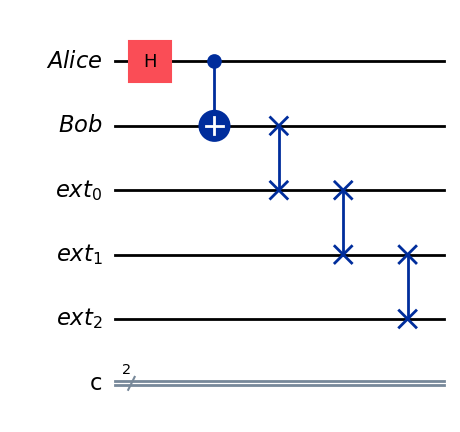

In [2]:
from qiskit import *

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

def entanglement(n=0):
    # 1) Cria registradores quânticos Alice e Bob
    alice = QuantumRegister(1, 'Alice')
    bob   = QuantumRegister(1, 'Bob')
    regs_q = [alice, bob]

    # 2) Se n>0, adiciona registrador extra "ext" com n qubits
    if n > 0:
        ext = QuantumRegister(n, 'ext')
        regs_q.append(ext)

    # 3) Cria registrador clássico com 1 bit
    c = ClassicalRegister(2, 'c')

    # 4) Monta o circuito incluindo TODOS os registradores
    qc = QuantumCircuit(*regs_q, c, name=f'entanglement(n={n})')

    # 5) Prepara o par de Bell entre Alice e Bob
    qc.h(alice[0])
    qc.cx(alice[0], bob[0])

    # 6) Se n>0, aplica cadeia de swaps: Bob ↔ ext[0] ↔ ext[1] ↔ …
    if n > 0:
        qc.swap(bob[0], ext[0])
        for i in range(1, n):
            qc.swap(ext[i-1], ext[i])

    return qc

# Exemplos:
c3 = entanglement(3)
display(c3.draw('mpl'))        # idem




In [59]:
rho_01= tomography2q(c3, targetA=0, targetB=1, shots=100000)
rho_04= tomography2q(c3, targetA=0, targetB=4, shots=100000)

print(rho_01)
print(rho_04)

[[ 5.0053e-01+0.00e+00j -2.0500e-04-1.24e-03j  3.2350e-03+5.35e-04j
  -7.2000e-04-1.85e-04j]
 [-2.0500e-04+1.24e-03j  2.3000e-04+0.00e+00j -7.0000e-05+6.85e-04j
   7.9500e-04+2.95e-04j]
 [ 3.2350e-03-5.35e-04j -7.0000e-05-6.85e-04j  4.9947e-01+0.00e+00j
   1.5000e-05+4.00e-05j]
 [-7.2000e-04+1.85e-04j  7.9500e-04-2.95e-04j  1.5000e-05-4.00e-05j
  -2.3000e-04+0.00e+00j]]
[[ 5.0118e-01+0.00e+00j -8.7000e-04+4.05e-04j -4.1000e-04+9.45e-04j
   5.0000e-01-1.15e-03j]
 [-8.7000e-04-4.05e-04j  1.9000e-04+0.00e+00j  0.0000e+00-8.20e-04j
  -1.1200e-03-2.50e-05j]
 [-4.1000e-04-9.45e-04j  0.0000e+00+8.20e-04j -1.9000e-04+0.00e+00j
  -5.4000e-04-3.05e-04j]
 [ 5.0000e-01+1.15e-03j -1.1200e-03+2.50e-05j -5.4000e-04+3.05e-04j
   4.9882e-01+0.00e+00j]]


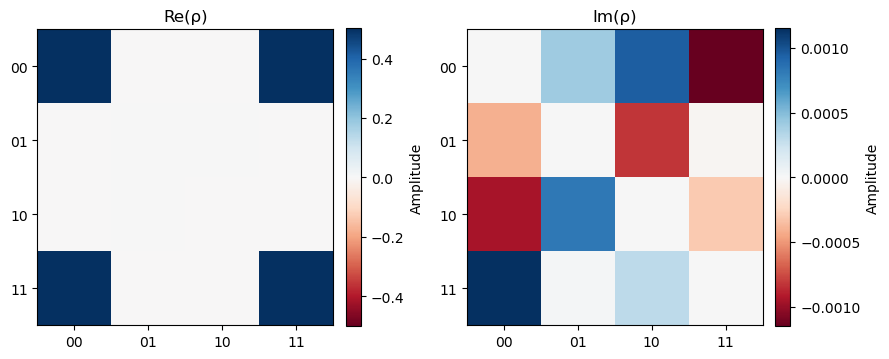

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# rho já calculada
rho = np.asarray(rho_04, dtype=complex)

labels = ['00','01','10','11']
n = 4

# crie 2 subplots lado a lado
fig, (axr, axi) = plt.subplots(1, 2, figsize=(9,4))

# 1) PARTE REAL --------------------------------------------------------
re = rho.real
maxr = np.abs(re).max()
im0 = axr.imshow(re, vmin=-maxr, vmax=+maxr, cmap='RdBu')
axr.set_title('Re(ρ)')
axr.set_xticks(range(n)); axr.set_xticklabels(labels)
axr.set_yticks(range(n)); axr.set_yticklabels(labels)
cbar_r = fig.colorbar(im0, ax=axr, fraction=0.046, pad=0.04)
cbar_r.set_label('Amplitude')

# 2) PARTE IMAGINÁRIA --------------------------------------------------
im = rho.imag
maxi = np.abs(im).max()
im1 = axi.imshow(im, vmin=-maxi, vmax=+maxi, cmap='RdBu')
axi.set_title('Im(ρ)')
axi.set_xticks(range(n)); axi.set_xticklabels(labels)
axi.set_yticks(range(n)); axi.set_yticklabels(labels)
cbar_i = fig.colorbar(im1, ax=axi, fraction=0.046, pad=0.04)
cbar_i.set_label('Amplitude')

plt.tight_layout()
plt.show()


